In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from bibliotheque import *
from signal_tools import *

%matplotlib inline

PATH

In [3]:
root = '/crnldata/'

In [4]:
data_file = root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_staged.nc'

PARAMS

In [5]:
eeg_chans = ['Fp2-C4','C4-T4','T4-O2','Fz-Cz','Cz-Pz','Fp1-C3','C3-T3','T3-O1']
respi_chan = 'DEBIT'
ecg_chan = 'ECG'
eog_chans = ['EOGDt-A2','EOGG-A1']
sel_chans = ['Fp2-C4','C4-T4','T4-O2','Fz-Cz','Cz-Pz','Fp1-C3','C3-T3','T3-O1','DEBIT','ECG']
stages = ['W','R','N1','N2','N3']

In [6]:
step = 40
start_freq = 10
stop_freq = 20

In [7]:
srate = 256
range_freqs = 10

amp = 1
time_cmw = np.arange(-2,2,1/srate)
range_freqs = np.linspace(start_freq,stop_freq,step)
n_cycles = np.linspace(5,10,step)
m = 0

cmw_family_params = {'amp':amp, 'time':time_cmw, 'n_cycles':n_cycles, 'm':m, 'range':range_freqs}

save = False

TOOLS

GO

In [8]:
if save:
    da = xr.load_dataarray(data_file)
    da = da.sel(stage = 'N2').dropna(dim='time')
    chans = list(da.coords['chan'].values)
    
    concat = []
    for chan in eeg_chans:
        print(chan)
        sig = da.loc[chan, :].dropna(dim='time').values
        time_sig = time_vector(sig=sig, srate=srate)
        da_features = extract_features_from_cmw_family(sig, time_sig, cmw_family_params)
        concat.append(da_features)
    da_all_features = xr.concat(concat, dim = 'chan')
    da_all_features = da_all_features.assign_coords({'chan':eeg_chans})
    
    da_all_features.to_netcdf(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_features_all.nc')
else:
    da_all_features = xr.load_dataarray(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_features_all.nc')

In [9]:
da_all_features

<xarray.DataArray 'features' (chan: 8, freqs: 40, time: 2903040)>
array([[[ 41.71820191,  42.01871752,  42.25907084, ..., 176.98521295,
         177.78958699, 178.22183132],
        [ 41.40938337,  41.74025311,  42.01006655, ..., 170.07257752,
         170.95133956, 171.47153387],
        [ 40.87277841,  41.21187837,  41.48846434, ..., 163.04373833,
         164.0507206 , 164.70720686],
        ...,
        [ 20.2833539 ,  20.22033417,  20.11540199, ...,  72.94395794,
          74.21489337,  75.2515321 ],
        [ 21.48056262,  21.51488531,  21.51095407, ...,  70.0219319 ,
          71.33852949,  72.42578872],
        [ 22.66739451,  22.79567501,  22.88864992, ...,  67.77983676,
          69.08053901,  70.16243836]],

       [[231.17125927, 230.87038396, 229.97616258, ..., 295.73669813,
         297.32512185, 298.21666683],
        [222.32690544, 221.81893187, 220.72530901, ..., 286.91143987,
         288.59400531, 289.58872579],
        [214.17020339, 213.4795777 , 212.21057001, ..., 278.32946189,
         280.11394112, 281.21893289],
...
        [427.41809696, 427.14888329, 425.83213849, ..., 201.38143324,
         203.66660026, 205.40982953],
        [421.089788  , 420.79762801, 419.47210694, ..., 198.82877783,
         201.08911972, 202.81407182],
        [414.99798916, 414.68594429, 413.35434623, ..., 196.8228408 ,
         199.0200492 , 200.69084653]],

       [[436.48852116, 434.24097758, 430.83068183, ..., 377.0807785 ,
         376.03660604, 374.29605761],
        [430.0539672 , 428.45666866, 425.77210807, ..., 368.56903268,
         367.62072892, 365.98207427],
        [424.20665711, 423.20218696, 421.17553295, ..., 358.85691377,
         358.1312589 , 356.71276451],
        ...,
        [234.8192152 , 234.46549498, 233.52387926, ..., 162.47343935,
         163.96233973, 165.01865525],
        [231.07844143, 230.66289753, 229.66364006, ..., 162.63096669,
         163.90354113, 164.76045071],
        [227.58847349, 227.12564377, 226.08399309, ..., 162.99377707,
         164.03458452, 164.67763476]]])
Coordinates:
    feature  <U5 'power'
  * freqs    (freqs) float64 10.0 10.26 10.51 10.77 ... 19.23 19.49 19.74 20.0
  * time     (time) float64 0.0 0.003906 0.007812 ... 1.134e+04 1.134e+04
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'

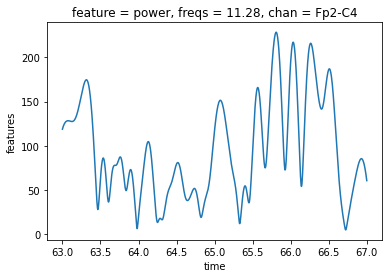

In [10]:
da_all_features.loc['Fp2-C4',range_freqs[5],63:67].plot()

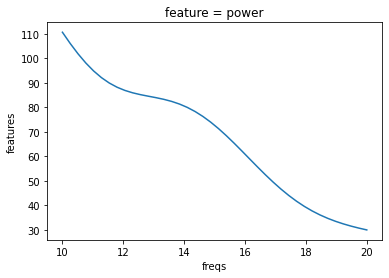

In [17]:
da_all_features.loc[:,:,:].mean(['time','chan']).plot()

In [11]:
if save:
    resp_features = pd.read_excel(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/df_analyse/resp_features.xlsx')
    da_tf_stretched = None
    for chan in eeg_chans:
        print(chan)
        for fi in range_freqs:
            sig = da_all_features.loc[chan, fi, :].values
            sig_stretched = stretch_data(resp_features=resp_features, nb_point_by_cycle=1000, data=sig, srate=srate)
            if da_tf_stretched is None:
                da_tf_stretched = init_da({'chan':eeg_chans, 'cycle':np.arange(0,sig_stretched.shape[0],1), 'freq':range_freqs, 'point':np.arange(0,sig_stretched.shape[1],1)})
            da_tf_stretched.loc[chan, : , fi, :] = sig_stretched      
    da_tf_stretched.to_netcdf(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_tf_stretched.nc')
else:
    da_tf_stretched = xr.load_dataarray(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_tf_stretched.nc')

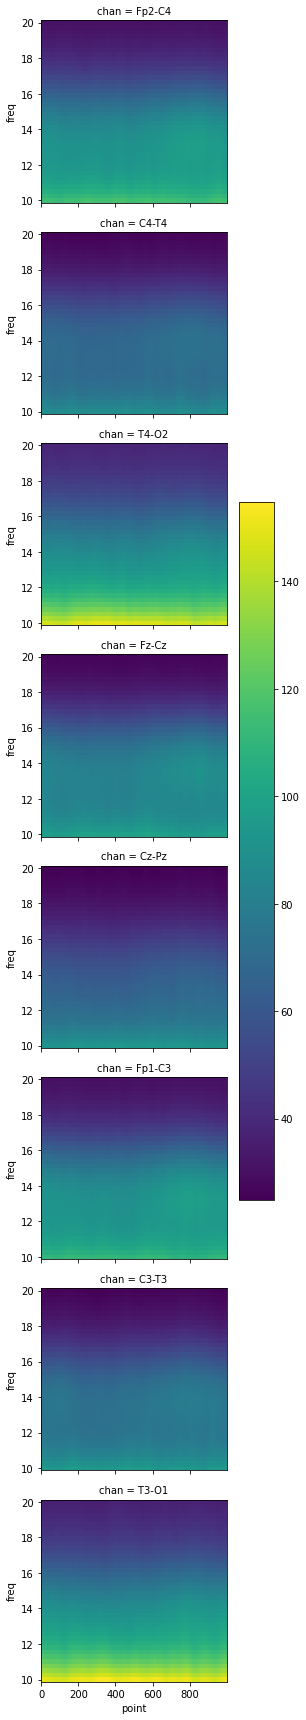

In [20]:
da_tf_stretched.loc[:,:,:,:].mean('cycle').plot.pcolormesh(x='point', row = 'chan')

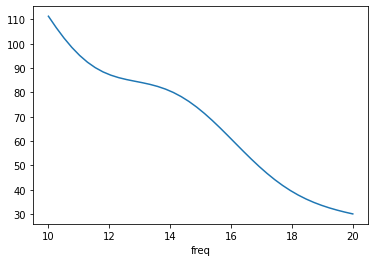

In [19]:
da_tf_stretched.loc[:,:,:,:].mean(['cycle','chan','point']).plot()

In [21]:
da_tf_stretched.coords

Coordinates:
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'
  * cycle    (cycle) int64 0 1 2 3 4 5 6 ... 3910 3911 3912 3913 3914 3915 3916
  * freq     (freq) float64 10.0 10.26 10.51 10.77 ... 19.23 19.49 19.74 20.0
  * point    (point) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

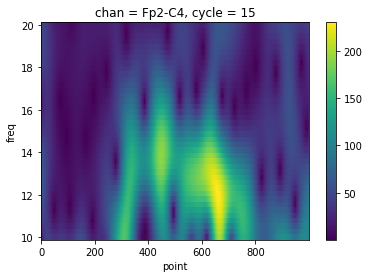

In [33]:
da_tf_stretched.loc['Fp2-C4',15,:,:].plot()

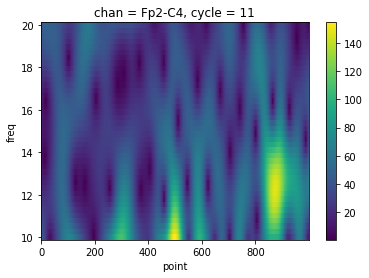

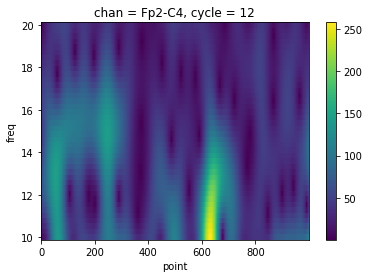

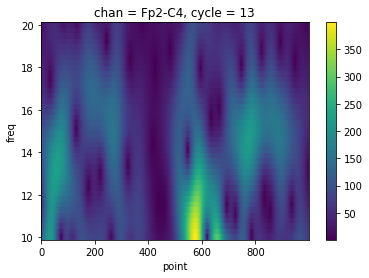

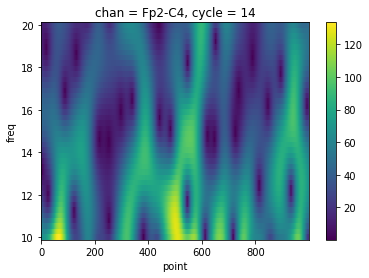

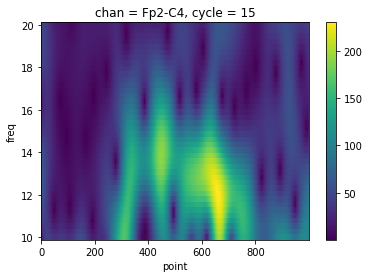

In [26]:
for i in range(10,15):
    da_tf_stretched.loc['Fp2-C4',i+1,:,:].plot.line(x='point')
    plt.show()

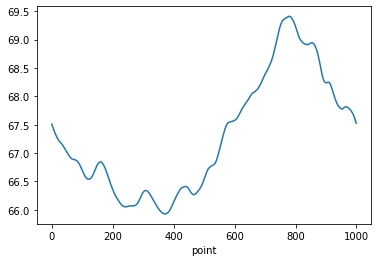

In [28]:
da_tf_stretched.mean(['chan','cycle','freq']).plot()